In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import seaborn as sns

In [ ]:
data = pd.read_csv('mlbdata.csv')

In [ ]:
mlbdata = data.iloc[:, :44]
mlbdata.head()

,#Bat,BatAge,PA,AB,R/G,2B,3B,HR,SB,CS,...,CG_F,Ch,E,DP,Rtot,BPF,#a-tA-S,1Run,Under500,SOS
0,36,27.2,38.316129,34.051613,4.05,1.200000,0.109677,0.929032,0.303226,0.225806,...,7.380645,38.193548,1.006452,0.838710,-38,109,13,0.536,0.458,0.1
1,32,28.7,36.857143,32.649351,3.37,1.253247,0.188312,0.649351,0.506494,0.266234,...,7.155844,38.090909,0.649351,0.974026,78,103,17,0.448,0.448,0.0
2,38,28.9,37.883871,33.600000,4.13,1.477419,0.219355,0.800000,0.425806,0.193548,...,7.580645,37.967742,0.838710,0.909677,-43,106,19,0.579,0.445,0.0
3,40,29.1,36.387097,33.322581,2.93,1.103226,0.167742,0.503226,0.367742,0.238710,...,7.245161,37.761290,0.735484,0.870968,8,94,12,0.567,0.361,0.0
4,41,30.0,38.147436,33.634615,4.39,1.320513,0.256410,0.852564,0.442308,0.301282,...,7.410256,39.852564,0.846154,0.948718,-25,110,16,0.449,0.551,-0.1


In [ ]:
# All feature variables are then normalized using Min Max Normalization to scale the data.

mlbdatanorm = pd.DataFrame(mlbdata)
mlbdatanormal = (mlbdatanorm - mlbdatanorm.min()) / (mlbdatanorm.max()-mlbdatanorm.min())

# Target variable is inserted back into the dataset, and renamed 'WinningRecord'. 

mlbdatanormal.insert(44,'WinningRecord',data['W-L%'])

In [ ]:
# Feature variable (win/loss percentage) is converted into a binary class variable represented by values 0 and 1.

mlbdatanormal['WinningRecord'] = ((mlbdatanormal['WinningRecord'] >= .500).replace({True: 1, False: 0}))

In [ ]:
X = mlbdatanormal.iloc[:,0:-1]
y = mlbdatanormal['WinningRecord']

In [ ]:
from sklearn.model_selection import train_test_split
from collections import defaultdict
from operator import itemgetter
from sklearn.feature_selection import SelectKBest, mutual_info_classif
mic = SelectKBest(score_func=mutual_info_classif)

In [ ]:
# Train/test split and mutual information algorithm is run through 250 seperate iterations and appended to a list.
# The resulting scores are then divided by the total number of iterations to generate a final dependancy ranking.

dicts = defaultdict(list)
finallist = []
for num in range(250):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
  fit = mic.fit(X_train,y_train)
  dfscores = pd.DataFrame(fit.scores_)
  dfcolumns = pd.DataFrame(X_train.columns)
  featureScores = pd.concat([dfcolumns,dfscores], axis=1)
  featureScores.columns = ['Feature','Score']
  keys = featureScores.index
  values = featureScores.loc[:,'Score']
  for i in keys:
    dicts[i].append(values[i])
for k, v in (dicts.items()):
  total = np.sum(v)
  np.sort(total, axis=None)
  final = (k, total/250)
  finallist.append(final)

In [ ]:
finaldf = pd.DataFrame(finallist, columns=['Feature', 'Score'])

In [ ]:
allFeatures = featureScores.nlargest(44, 'Score')
allFeatures

,Feature,Score
32,ERA+,0.207229
12,OPS+,0.171607
20,RA/G,0.160237
22,SV,0.128710
41,1Run,0.114884
42,Under500,0.097407
26,BB_P,0.086893
24,H_P,0.083897
4,R/G,0.081322
40,#a-tA-S,0.080874


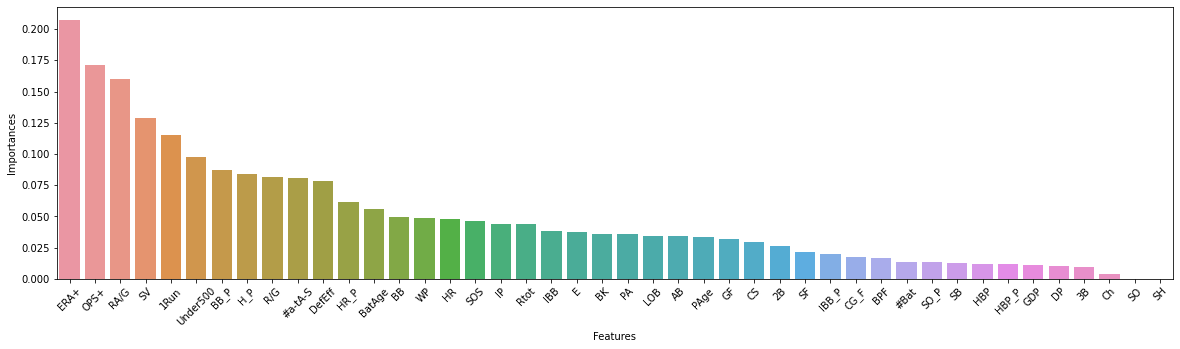

In [ ]:
# A visual representation of variable dependancy ranked from highest to lowest.

importances = allFeatures['Score']
final_df2 = pd.DataFrame({'Features': allFeatures['Feature'], 'Importances':importances})
final_df2.set_index('Importances')

final_df2 = final_df2.sort_values('Importances', ascending=False)
plt.figure(figsize=(20,5))
plt.xticks(rotation=45)
sns.barplot(x='Features',y='Importances', data=final_df2)

In [ ]:
# The features are ordered from highest dependancy to lowest, and a new dataset is created.
# This dataset will be used to complete the final step in the dimensionality reduction, where a set number of variables will be selected for machine learning. 

featuresRanked = []
for i in allFeatures['Feature'].head(44):
  featuresRanked.append(i) 

In [ ]:
featuresRankedMIC = mlbdatanormal[featuresRanked + ['WinningRecord']]

In [ ]:
featuresRankedMIC.to_csv("featuresRankedMIC.csv")